#Cuestiones generales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Train set

Descargo y leo los csv

In [2]:
id = '1jV8hjb6D1ULTcwrCi5m7eogJGHAGVDAd'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train.csv')

train = pd.read_csv('train.csv')

In [3]:
id = '1-0xMHFYwBWopWLouS2_oib1FwGHiUgr0'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('validation.csv')

validation = pd.read_csv('validation.csv')

In [4]:
train.head()

,Unnamed: 0,isFraud,ProductCD,card3,card6,R_emaildomain,C7,C12,M4,V15,V16,V17,V18,V21,V22,V23,V31,V32,V33,V34,V37,V38,V39,V40,V42,V43,V44,V45,V47,V50,V51,V52,V57,V58,V59,V60,V63,V64,V71,V72,...,V186,V188,V189,V190,V191,V194,V197,V199,V200,V201,V221,V222,V228,V229,V230,V242,V243,V244,V245,V246,V247,V248,V249,V252,V254,V257,V258,V259,V262,V282,V283,V302,V303,V304,id_33,DeviceInfo,android,chrome,"('mobile',)","(nan,)"
0,177162,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.028990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
1,177163,1,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,2.0,6.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
2,177164,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.028990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,2.0,13.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
3,177165,1,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,3.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
4,177166,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0


In [5]:
validation.head()

,Unnamed: 0,isFraud,ProductCD,card3,card6,R_emaildomain,C7,C12,M4,V15,V16,V17,V18,V21,V22,V23,V31,V32,V33,V34,V37,V38,V39,V40,V42,V43,V44,V45,V47,V50,V51,V52,V57,V58,V59,V60,V63,V64,V71,V72,...,V186,V188,V189,V190,V191,V194,V197,V199,V200,V201,V221,V222,V228,V229,V230,V242,V243,V244,V245,V246,V247,V248,V249,V252,V254,V257,V258,V259,V262,V282,V283,V302,V303,V304,id_33,DeviceInfo,android,chrome,"('mobile',)","(nan,)"
0,0,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.123225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
1,1,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
2,2,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
3,3,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
4,4,0,0.095829,150.0,0.080659,0.107195,0.0,0.0,0.051507,0.114853,0.115119,0.125419,0.126085,0.121369,0.123789,1.034559,0.129383,0.130101,0.126064,0.136202,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.11812,0.122731,0.125129,0.133835,0.12177,0.133793,0.128688,0.133586,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0.092105,0.000000,0,0,1.0,0.0


In [6]:
train.set_index('Unnamed: 0', inplace=True)

In [7]:
train.head()

,isFraud,ProductCD,card3,card6,R_emaildomain,C7,C12,M4,V15,V16,V17,V18,V21,V22,V23,V31,V32,V33,V34,V37,V38,V39,V40,V42,V43,V44,V45,V47,V50,V51,V52,V57,V58,V59,V60,V63,V64,V71,V72,V73,...,V186,V188,V189,V190,V191,V194,V197,V199,V200,V201,V221,V222,V228,V229,V230,V242,V243,V244,V245,V246,V247,V248,V249,V252,V254,V257,V258,V259,V262,V282,V283,V302,V303,V304,id_33,DeviceInfo,android,chrome,"('mobile',)","(nan,)"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
177162,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.028990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177163,1,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.000000,2.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,2.0,6.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177164,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.028990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,2.0,13.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177165,1,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,3.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
177166,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0


In [8]:
validation.set_index('Unnamed: 0', inplace=True)

In [9]:
validation.head()

,isFraud,ProductCD,card3,card6,R_emaildomain,C7,C12,M4,V15,V16,V17,V18,V21,V22,V23,V31,V32,V33,V34,V37,V38,V39,V40,V42,V43,V44,V45,V47,V50,V51,V52,V57,V58,V59,V60,V63,V64,V71,V72,V73,...,V186,V188,V189,V190,V191,V194,V197,V199,V200,V201,V221,V222,V228,V229,V230,V242,V243,V244,V245,V246,V247,V248,V249,V252,V254,V257,V258,V259,V262,V282,V283,V302,V303,V304,id_33,DeviceInfo,android,chrome,"('mobile',)","(nan,)"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.123225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
1,0,0.021053,150.0,0.080659,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
2,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
3,0,0.021053,150.0,0.025510,0.107195,0.0,0.0,0.037299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.076710,0.104684,0,0,0.0,1.0
4,0,0.095829,150.0,0.080659,0.107195,0.0,0.0,0.051507,0.114853,0.115119,0.125419,0.126085,0.121369,0.123789,1.034559,0.129383,0.130101,0.126064,0.136202,1.103761,1.158857,0.146788,0.157945,0.13775,0.150655,1.084039,1.120623,1.035898,0.143738,0.158898,0.172663,0.11812,0.122731,0.125129,0.133835,0.12177,0.133793,0.128688,0.133586,0.132513,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,0.092105,0.000000,0,0,1.0,0.0


Limpio la RAM

In [10]:
downloaded = None

#Hiperparámetros

Separo labels y points en train set

In [35]:
points_train = train.drop(columns=['isFraud'])
labels_train = pd.DataFrame(train['isFraud'])

Utilizo la librería sklearn para hacer un random forest regression con los mejores parámetros posibles

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(random_state=13)

In [38]:
parametros = [{
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 400, 700, 1000, 1300, 1700, 2000]
}]

In [39]:
model = RandomizedSearchCV(rf, param_distributions=parametros, n_iter=20, random_state=13, scoring='roc_auc', n_jobs=1, verbose=100, cv=2)

In [40]:
model.fit(points_train, labels_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2; 1/20] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 1/20] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.848 total time= 8.2min
[CV 2/2; 1/20] START bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 1/20] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.834 total time= 8.0min
[CV 1/2; 2/20] START bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 2/20] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700;, score=0.853 total time= 4.1min
[CV 2/2; 2/20] START bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 2/20] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=700;, score=0.838 total time= 3.9min
[CV 1/2; 3/20] START bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 3/20] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000;, score=0.853 total time=19.0min
[CV 2/2; 3/20] START bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 3/20] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=2000;, score=0.840 total time=18.6min
[CV 1/2; 4/20] START bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 4/20] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.838 total time= 3.1min
[CV 2/2; 4/20] START bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 4/20] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000;, score=0.824 total time= 2.9min
[CV 1/2; 5/20] START bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 5/20] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=0.850 total time= 2.6min
[CV 2/2; 5/20] START bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 5/20] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=0.837 total time= 2.5min
[CV 1/2; 6/20] START bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 6/20] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.840 total time=  18.8s
[CV 2/2; 6/20] START bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 6/20] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.824 total time=  20.1s
[CV 1/2; 7/20] START bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 7/20] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.849 total time= 3.0min
[CV 2/2; 7/20] START bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 7/20] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=0.838 total time= 2.9min
[CV 1/2; 8/20] START bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 8/20] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1700;, score=0.834 total time= 4.6min
[CV 2/2; 8/20] START bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 8/20] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1700;, score=0.821 total time= 4.4min
[CV 1/2; 9/20] START bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 9/20] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.829 total time=21.0min
[CV 2/2; 9/20] START bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 9/20] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.827 total time=20.1min
[CV 1/2; 10/20] START bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 10/20] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.838 total time=  24.0s
[CV 2/2; 10/20] START bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 10/20] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.823 total time=  22.8s
[CV 1/2; 11/20] START bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 11/20] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.853 total time=  44.5s
[CV 2/2; 11/20] START bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 11/20] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.838 total time=  42.6s
[CV 1/2; 12/20] START bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 12/20] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.835 total time= 4.5min
[CV 2/2; 12/20] START bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 12/20] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.821 total time= 4.3min
[CV 1/2; 13/20] START bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 13/20] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.854 total time= 2.4min
[CV 2/2; 13/20] START bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 13/20] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.839 total time= 2.3min
[CV 1/2; 14/20] START bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 14/20] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.848 total time=  46.2s
[CV 2/2; 14/20] START bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 14/20] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.837 total time=  45.1s
[CV 1/2; 15/20] START bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 15/20] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.852 total time=  55.9s
[CV 2/2; 15/20] START bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 15/20] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.839 total time=  55.3s
[CV 1/2; 16/20] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 16/20] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1700;, score=0.852 total time=12.7min
[CV 2/2; 16/20] START bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 16/20] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1700;, score=0.838 total time=12.0min
[CV 1/2; 17/20] START bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 17/20] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=700;, score=0.833 total time= 4.0min
[CV 2/2; 17/20] START bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 17/20] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=700;, score=0.826 total time= 3.9min
[CV 1/2; 18/20] START bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 18/20] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=700;, score=0.833 total time= 1.5min
[CV 2/2; 18/20] START bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 18/20] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=700;, score=0.820 total time= 1.5min
[CV 1/2; 19/20] START bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 19/20] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1700;, score=0.810 total time=19.5min
[CV 2/2; 19/20] START bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1700


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 19/20] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1700;, score=0.811 total time=19.0min
[CV 1/2; 20/20] START bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 1/2; 20/20] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=2000;, score=0.854 total time=11.9min
[CV 2/2; 20/20] START bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=2000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


[CV 2/2; 20/20] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=2000;, score=0.839 total time=11.6min


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=13),
                   n_iter=20, n_jobs=1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [10, 20, 30, 40, 50],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'min_samples_leaf': [1, 2, 4],
                                         'min_samples_split': [2, 5, 10],
                                         'n_estimators': [100, 400, 700, 1000,
                                                          1300, 1700, 2000]}],
                   random_state=13, scoring='roc_auc', verbose=100)

In [41]:
model.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=2000, random_state=13)

#Random Forest Classifier

In [11]:
points_train = train.drop(columns=['isFraud'])
labels_train = pd.DataFrame(train['isFraud'])

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
rf = RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=2000, random_state=13)

In [14]:
rf.fit(points_train, labels_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=2000, random_state=13)

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
points_validation = validation.drop(columns=['isFraud'])
labels_validation = pd.DataFrame(validation['isFraud'])

In [17]:
roc_auc_score(labels_validation, rf.predict_proba(points_validation)[:, 1])

0.8404605184719457

#Importancia features

In [18]:
feature_importance = pd.DataFrame(rf.feature_importances_, index=points_train.columns, columns=['importance']).sort_values('importance', ascending=False)

In [19]:
feature_importance.head(10)

,importance
DeviceInfo,0.088422
V258,0.046292
C12,0.045061
V201,0.041082
V257,0.040852
V283,0.038442
V200,0.031204
V246,0.030599
C7,0.028554
V45,0.027276


Text(0.5, 1.0, 'Los 10 features más importantes')

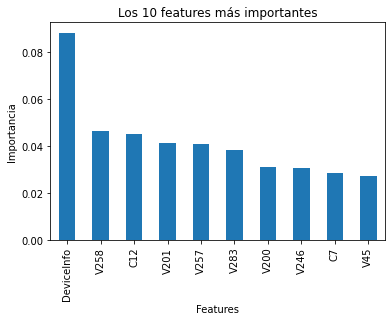

In [20]:
feature_importance.head(10)['importance'].plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Los 10 features más importantes')

In [21]:
feature_importance = None

#Matriz de confusión

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [23]:
conf_matrix = confusion_matrix(labels_validation, rf.predict(points_validation))
conf_matrix

array([[170593,   1544],
       [  3350,   1676]])

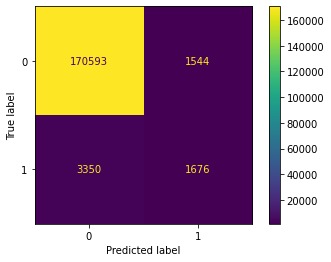

In [24]:
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

In [25]:
conf_matrix = None
disp = None

#Limpio la RAM

In [27]:
train = None
validation = None
points_train = None
points_validation = None
labels_train = None
labels_validation = None

#Test set

In [28]:
id = '1-2AhaCoP1jVzf3uCJe1HVhH1mx9JH6yI'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('df_test.csv')

df_test = pd.read_csv('df_test.csv')

In [35]:
id = '1QrkmQ3Yqe5OGzdCh0Ej9noTI30lFlI2B'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('ids.csv')

ids = pd.read_csv('ids.csv')

In [29]:
df_test.head()

,Unnamed: 0,ProductCD,card3,card6,R_emaildomain,C7,C12,M4,V15,V16,V17,V18,V21,V22,V23,V31,V32,V33,V34,V37,V38,V39,V40,V42,V43,V44,V45,V47,V50,V51,V52,V57,V58,V59,V60,V63,V64,V71,V72,V73,...,V186,V188,V189,V190,V191,V194,V197,V199,V200,V201,V221,V222,V228,V229,V230,V242,V243,V244,V245,V246,V247,V248,V249,V252,V254,V257,V258,V259,V262,V282,V283,V302,V303,V304,id_33,DeviceInfo,android,chrome,"('mobile',)","(nan,)"
0,0,0.021053,150.0,0.02551,0.107195,0.0,1.0,0.051507,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
1,1,0.021053,150.0,0.02551,0.107195,0.0,1.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
2,2,0.021053,150.0,0.02551,0.107195,0.0,0.0,0.037299,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,0.0,0.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
3,3,0.021053,150.0,0.02551,0.107195,0.0,0.0,0.051507,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0
4,4,0.021053,150.0,0.02551,0.107195,0.0,0.0,0.051507,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.131836,1.030434,1.064345,1.216707,1.035779,0.93518,0.93684,1.285901,1.166581,1.223588,1.283296,1.390153,1.465709,1.715876,1.573082,1.151636,1.199022,1.160753,0.844696,1.252795,1.029979,1.057432,1.039691,1.031605,1.04438,1.342963,1.421111,0.957847,1.009538,1.0,1.0,0.0,0.0,0.0,0.07671,0.104684,0,0,0.0,1.0


In [30]:
downloaded = None

In [34]:
df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [36]:
ids.head()

,TransactionID
0,3663549
1,3663550
2,3663551
3,3663552
4,3663553


#Predicciones

Este fue el mejor modelo así que lo envío a la competencia

In [37]:
df_predictions = pd.DataFrame(list(rf.predict_proba(df_test)[:, 1]))

In [38]:
df_predictions['TransactionID'] = ids

In [39]:
df_predictions.columns = ['isFraud', 'TransactionID']

In [40]:
df_predictions.head(10)

,isFraud,TransactionID
0,0.006910,3663549
1,0.018572,3663550
2,0.009086,3663551
3,0.007196,3663552
4,0.005377,3663553
5,0.005377,3663554
6,0.017066,3663555
7,0.043434,3663556
8,0.004601,3663557
9,0.025032,3663558


In [41]:
df_predictions = df_predictions[['TransactionID', 'isFraud']]

In [42]:
df_predictions.head(10)

,TransactionID,isFraud
0,3663549,0.006910
1,3663550,0.018572
2,3663551,0.009086
3,3663552,0.007196
4,3663553,0.005377
5,3663554,0.005377
6,3663555,0.017066
7,3663556,0.043434
8,3663557,0.004601
9,3663558,0.025032


In [43]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [44]:
df_predictions.to_csv('RANDOM_FOREST.csv', index=False)
!cp RANDOM_FOREST.csv "drive/My Drive/"

El score obtenido en la competencia es 0.869875